In [1]:
import geopandas as gpd
import osmnx
import shapely
import pandas as pd
import numpy as np
import networkx as nx

from shapely.geometry import Point, Polygon
from collections import Counter
from sklearn.neighbors import BallTree
from mlxtend.frequent_patterns import association_rules, apriori

# Is it true that schools are often neighbours with pharmacies in Almaty, Kazakhstan?

### Find interesting amenitites in Almaty and get their coords. We will take into account schools, police depts, pharmacies, hospitals, universities and fuel stations.

In [24]:
def point_finder(place, tags):
    '''
    Returns a dataframe of coordinates of an entity from OSM.

            Parameters:
                    place (str): a location (i.e., 'Almaty')
                    tags (dict): key value of amenity attribute in OSM (i.e., 'Name') and value (i.e., amenity name)
            Returns:
                    results (DataFrame): table of latitude and longitude with entity value 
    '''

    gdf = osmnx.geocode_to_gdf(place)
    #Getting the bounding box of the gdf
    bounding = gdf.bounds
    north, south, east, west = bounding.iloc[0,3], bounding.iloc[0,1], bounding.iloc[0,2], bounding.iloc[0,0]
    location = gdf.geometry.unary_union
    #Finding the points within the area polygon
    point = osmnx.features_from_bbox(north,
                                       south,
                                       east,
                                       west,
                                       tags=tags)
    point.set_crs(crs=4326)
    point = point[point.geometry.within(location)]
    #Making sure we are dealing with points
    point['geometry'] = point['geometry'].apply(lambda x : x.centroid if type(x) == Polygon else x)
    point = point[point.geom_type != 'MultiPolygon']
    point = point[point.geom_type != 'Polygon']

    results = pd.DataFrame({'name' : list(point['name']),
                            'longitude' : list(point['geometry'].x),
                            'latitude' : list(point['geometry'].y)}
                            )

    results['name'] = list(tags.values())[0]
    return results

In [3]:
school = point_finder(place = 'Aлматы',
                                  tags={"amenity" : "school"})
police = point_finder(place = 'Aлматы',
                                  tags={"amenity" : "police"})
pharmacy = point_finder(place = 'Aлматы',
                                  tags={"amenity" : "pharmacy"})
hospital = point_finder(place = 'Aлматы',
                                  tags={"amenity" : "hospital"})
university = point_finder(place = 'Aлматы',
                                  tags={"amenity" : "university"})
fuel = point_finder(place = 'Aлматы',
                                  tags={"amenity" : "fuel"})

In [4]:
amenities = pd.concat([school,police,pharmacy,hospital,university,fuel,
                               ], axis=0).reset_index()

In [5]:
amenities = amenities.drop(columns=['index'])

In [22]:
school.to_csv('school.csv')
pharmacy.to_csv('pharmacy.csv')


### Find nearest (<500m) neighbours between amenities

In [20]:
# Convert location to radians
locations = amenities[["latitude", "longitude"]].values
locations_radians =  np.radians(locations)

# Create a balltree to search locations
tree = BallTree(locations_radians, leaf_size=15, metric='haversine')

# Find nearest neighbours in a 500 meters radius
is_within, distances = tree.query_radius(locations_radians, r=500/6371000, count_only=False, return_distance=True)

# Replace the neighbour indices with amenity names
df = pd.DataFrame(is_within)
df.columns = ['indices']
df['indices'] = [[val for val in row if val != idx] for idx, row in enumerate(df['indices'])]

In [17]:
# create temporary index column
amenities = amenities.reset_index()
# set temporary index column as index
amenities = amenities.set_index('index')
# create index-name mapping
index_name_mapping = amenities['name'].to_dict()

# replace index values with names and remove duplicates
df['indices'] = df['indices'].apply(lambda lst: list(set(map(index_name_mapping.get, set(lst))))).dropna()
# Append back to original df
amenities['neighbours'] = df['indices']

# Identify when a store has no neighbours
amenities['neighbours'] = [lst if lst else ['no-neighbours'] for lst in amenities['neighbours']]

In [18]:
# Unique store names
unique_elements = set([item for sublist in amenities['neighbours'] for item in sublist])
# Count each stores frequency in the set of neighbours per location
counts = [dict(Counter(row)) for row in amenities['neighbours']]

# Create a new dataframe with the counts
output_df = pd.DataFrame(counts).fillna(0)[sorted(unique_elements)]

### Association Rule Mining

To ensure a focus on frequent occurrences in our dataset, we have set a minimum support of 5%. This allows us to examine only the rules that are associated with co-located amenities. When deriving these rules, we utilize the 'lift' metric, which represents the ratio of the proportion of locations containing both the antecedent and consequent, relative to the expected support assuming independence.

In [19]:
# Calculate apriori
frequent_set = apriori(output_df, min_support = 0.05, use_colnames = True)
# Create rules
rules = association_rules(frequent_set, metric = 'lift')
# Sort rules by the support value
rules.sort_values(['support'], ascending=False)

/home/ivan/anaconda3/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
19,(pharmacy),(school),0.649,0.609,0.481,0.741140,1.216979,0.085759,1.510470,0.507958
18,(school),(pharmacy),0.609,0.649,0.481,0.789819,1.216979,0.085759,1.669992,0.455993
2,(fuel),(pharmacy),0.499,0.649,0.320,0.641283,0.988109,-0.003851,0.978486,-0.023457
3,(pharmacy),(fuel),0.649,0.499,0.320,0.493066,0.988109,-0.003851,0.988295,-0.033149
8,(pharmacy),(hospital),0.649,0.354,0.289,0.445300,1.257911,0.059254,1.164594,0.584134
...,...,...,...,...,...,...,...,...,...,...
116,"(fuel, police)","(school, pharmacy)",0.093,0.481,0.055,0.591398,1.229517,0.010267,1.270184,0.205813
117,"(fuel, pharmacy)","(school, police)",0.320,0.126,0.055,0.171875,1.364087,0.014680,1.055396,0.392513
118,"(fuel, school)","(pharmacy, police)",0.284,0.145,0.055,0.193662,1.335600,0.013820,1.060349,0.350940
121,"(school, pharmacy)","(fuel, police)",0.481,0.093,0.055,0.114345,1.229517,0.010267,1.024101,0.359678


### Interpretation

1. The association between pharmacies and schools is the strongest, with a support of 0.481. This indicates that in 48.1% of cases, pharmacies are located near schools. The confidence value of 0.741 suggests that if a pharmacy is present, there is a 74.1% chance of a school being nearby. The lift value of 1.217 indicates a slightly positive correlation between pharmacies and schools.

    In order to enhance clarity, we will represent pharmacies with red dots and schools with yellow dots on the map.
    
2. Similarly, when considering schools as the antecedent and pharmacies as the consequent, we find a similar support value of 0.481. The confidence value of 0.790 indicates that if a school is present, there is a 79.0% chance of a nearby pharmacy. The lift value of 1.217 suggests a slightly positive correlation between schools and pharmacies.

3. The association between fuel and pharmacies has a support value of 0.320, indicating that in 32% of cases, pharmacies are located near fuel stations. The confidence value of 0.641 suggests that if a fuel station is present, there is a 64.1% chance of a nearby pharmacy. However, the negative leverage and conviction values indicate that the presence of fuel stations does not strongly influence the occurrence of pharmacies.

4. Conversely, when considering pharmacies as the antecedent and fuel as the consequent, we find a similar support value of 0.320. The confidence value of 0.493 indicates that if a pharmacy is present, there is a 49.3% chance of a nearby fuel station. Similar to the previous association, the negative leverage and conviction values suggest that the presence of pharmacies does not strongly influence the occurrence of fuel stations.

5. The association between pharmacies and hospitals has a support value of 0.289, indicating that in 28.9% of cases, pharmacies are located near hospitals. The confidence value of 0.445 suggests that if a pharmacy is present, there is a 44.5% chance of a nearby hospital. The lift value of 1.258 indicates a slightly positive correlation between pharmacies and hospitals.


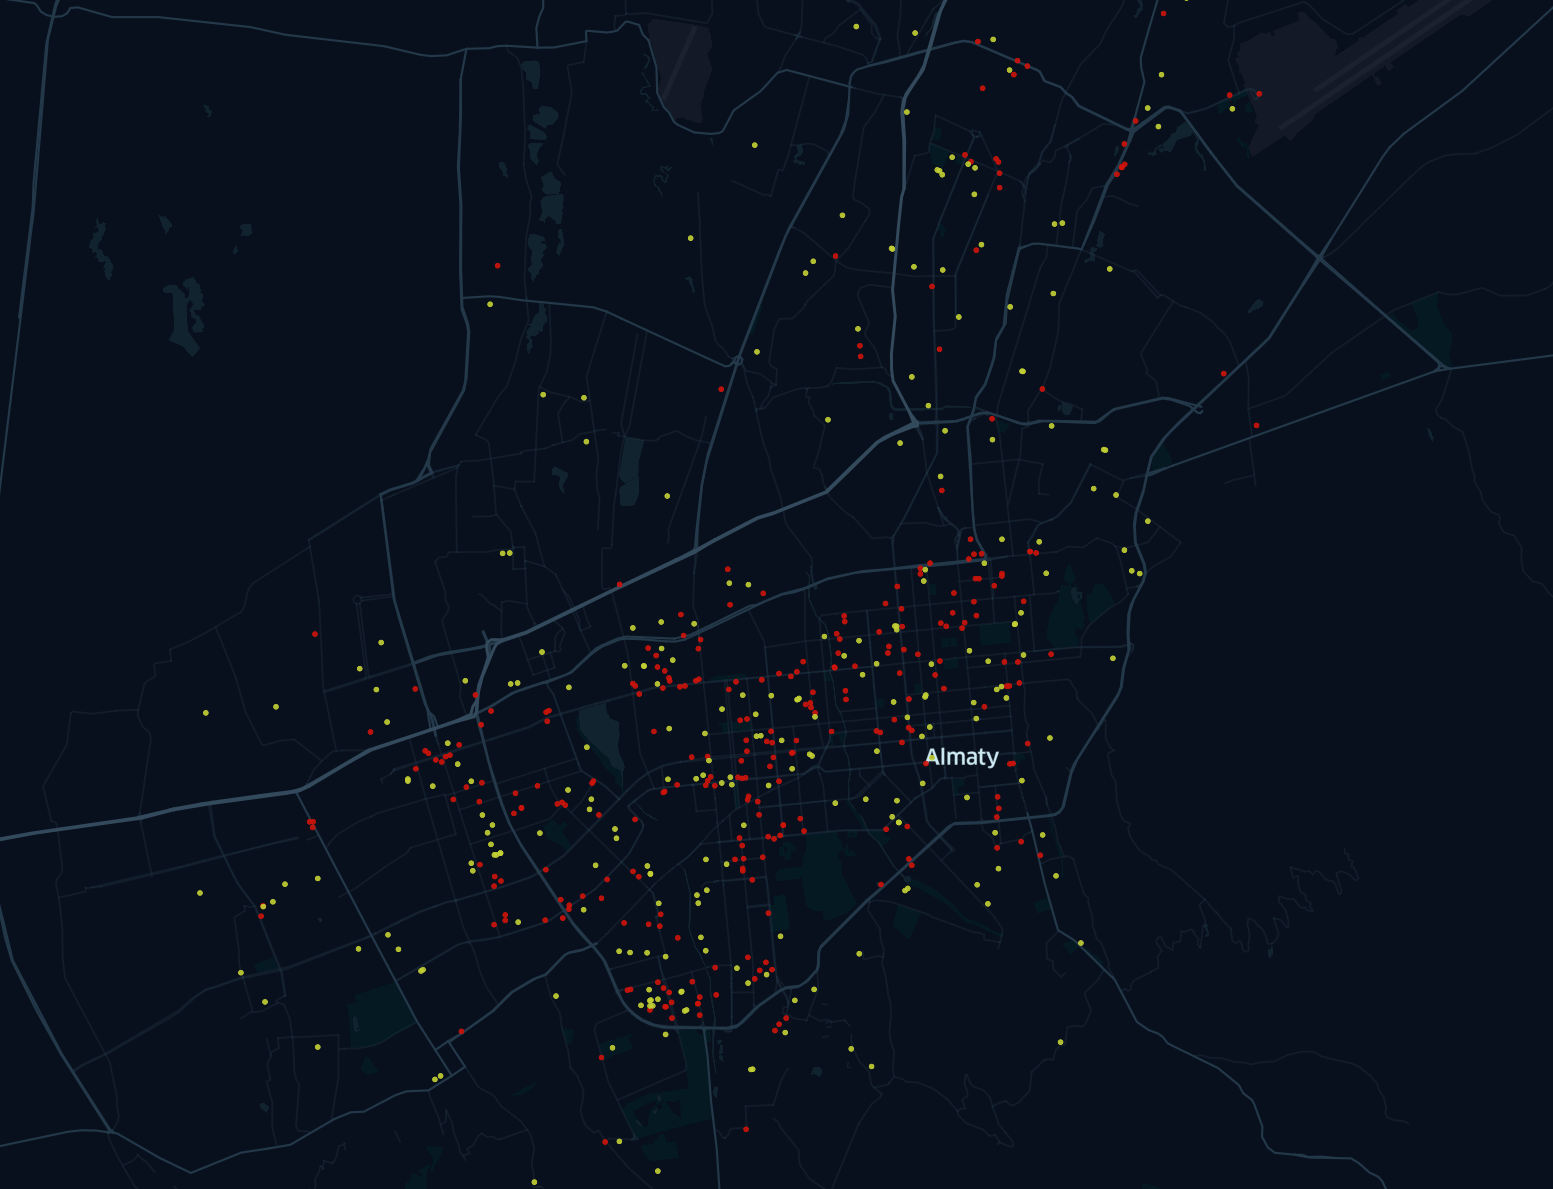